# Visualization and Explore the Wildfire Emissions Data Feature with Matplotlib, Pandas and Seaborn

This notebook will connect to a MySQL DB in the cloud which houses a combined table for wild
fires in the US and weather conditions during each fire. Features will be evalauted for multicollinearity  usefulness in a model. The goal of the model is to predict the burn serverity based on the fire features and the weather. This notebook relies on the emissions data set from the USDA. 

In [1]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

### Getting Started:
### Importing the libraries 

In [2]:
%matplotlib inline

import config #database connection variables 

import pandas as pd
import numpy as np

from sqlalchemy import create_engine   #sql engine

import yellowbrick as yb
from yellowbrick.features import RadViz
from yellowbrick.features import Rank2D
from yellowbrick.features import FeatureImportances
from yellowbrick.model_selection import LearningCurve

import pylab as pl
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


#from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
#from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder



### Connect to mySQL database in the cloud
The config files stored in the same directory as the notebook 
contains the connection information 

In [ ]:
# Skip this block if reading from disk

# create sqlalchemy engine
engine = create_engine("mysql+mysqlconnector://{user}:{password}@{host}/{dbname}"
                       .format(user=config.db_user,
                               password=config.db_pass,
                               dbname=config.db_main,
                               host=config.db_host))

### Query the machine learning table  
Setup the code to query the machine learning table in the database. Select all columns.


<i>Query the emissions. Limit the rows for initial exploration data</i>

In [ ]:
#Skip this block if reading from local disk

queryEmissions = """
SELECT *
FROM Emissions_Data
LIMIT 10000;
"""

In [ ]:
#Skip this block if reading from local disk

#Execute Queries
df_emissions = pd.read_sql(queryEmissions, engine)

#close the database connection
engine.dispose()

### Save the data to disk for faster access in the future
Store data in default data sub directory or folder

In [ ]:
#Save data to local disk

#Execute Queries
df_emissions.to_csv('data/emissions91.csv', index = False)

### Read data from disk previously stored for faster access 
Use .sample to get a a random sampling of the data. Descirbe the data.

In [3]:
#Read the data from disk for faster access
df_emissions = pd.read_csv('data/BSEV_Model_June13.csv').sample(100000)


In [ ]:
print(df_emissions.describe())

print(df_emissions.columns)

### Analyze the features in the machine learning table

<i> Drop adminstrative columns we already know are not relevant</i>

In [4]:
df_emissions = df_emissions.drop(columns=['Unnamed: 0', 'id', 'year','cluster_reference'])


#### Explore the data: head, shape and count by target


In [ ]:
df_emissions.head()

print (df_emissions.shape)

print(df_emissions.groupby('BSEV').count())


### Quick Data Fix
This dataset has already been cleaned and wrangled but found a minor error. This quick checks shows 2 instances with BSEV 0. BSEV should be between 1-4 (Low to high).
Will remove the 2 instances as an error.

In [5]:
# Get names of indexes for which column Age has value 30
index_errors = df_emissions[ df_emissions['BSEV'] == 0 ].index
df_emissions.drop(index_errors , inplace=True)
print(df_emissions.groupby('BSEV').count())


        doy  longitude  latitude  fire_bsev_region  season  covertype  \
BSEV                                                                    
1     19945      19945     19945             19945   19945      19945   
2     56503      56503     56503             56503   56503      56503   
3     16585      16585     16585             16585   16585      16585   
4      6967       6967      6967              6967    6967       6967   

      fuelcode  prefire_fuel  consumed_fuel  fuel_moisture_class  ...  \
BSEV                                                              ...   
1        19945         19945          19945                19945  ...   
2        56503         56503          56503                56503  ...   
3        16585         16585          16585                16585  ...   
4         6967          6967           6967                 6967  ...   

      humidity  precip_intensity  wind_speed  wind_gust  cwd_frac  duff_frac  \
BSEV                                      

### Visualize home many of each type of dependent variables we have (1-4)

Use yellowbrick to plot a count histogram. We have 4 separate categories.
1 (not burned), 2 (light), 3(med), 4 (heavy burn)

Not a great normal distribution but we'll fix that later. Will apply SMOTE To generate more features.

In [ ]:
sns.countplot(df_emissions['BSEV'],label="Count")
plt.show()

### Let's setup our Features, X and y to furhter visualize our data

In [ ]:
print(df_emissions.columns)

In [6]:

feature_names = ['doy', 'longitude', 'latitude', 'fire_bsev_region', 'season',
       'covertype', 'fuelcode', 'prefire_fuel', 'consumed_fuel',
       'fuel_moisture_class', 'temperature', 'humidity', 'precip_intensity',
       'wind_speed', 'wind_gust', 'cwd_frac', 'duff_frac', 'BSEV', 'ECO2',
       'ECO', 'ECH4', 'EPM2.5']


X = df_emissions[feature_names]
y = df_emissions['BSEV']
y = LabelEncoder().fit_transform(y)

### Check Feature multicollinearity 

From our research we know we have highly correlated features and some likely will need to be dropped.
Let's visualize this using a Pearson ranking. This confirms our research. 


In [ ]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()
    

### Drop the columns with high multicollinearity or are predictive and not availabe before a fire

Previous analysis als region and season were not effective binning categories so drop those two. 

In [ ]:
print(df_emissions.columns)
print(df_emissions.describe)

In [7]:
df_emissions = df_emissions.drop(columns=[ 'fire_bsev_region', 'season',
        'covertype', 'consumed_fuel', 'BSEV',
       'wind_gust', 'cwd_frac', 'duff_frac','ECO2',
       'ECO', 'ECH4', 'EPM2.5'])


print(df_emissions.columns)

Index(['doy', 'longitude', 'latitude', 'fuelcode', 'prefire_fuel',
       'fuel_moisture_class', 'temperature', 'humidity', 'precip_intensity',
       'wind_speed'],
      dtype='object')


In [8]:
#set feature names
feature_names = list(df_emissions.columns)

### Re-run Perason Ranking with reduced columns 
Much less multicollinearity and lets label encode y.

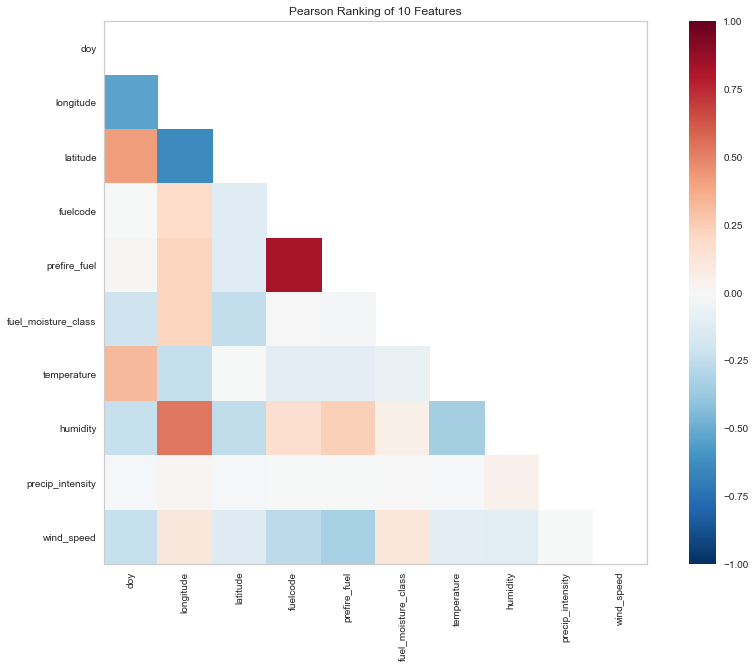

In [9]:

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

X = df_emissions[feature_names]

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()


### Draw box diagram to see scale and quartiles of data
Data is on a very large scale with could affect some models scaling maybe needed.

Prefire fuel is quite large so may require scaling and fuel code is really a label typed as a number.


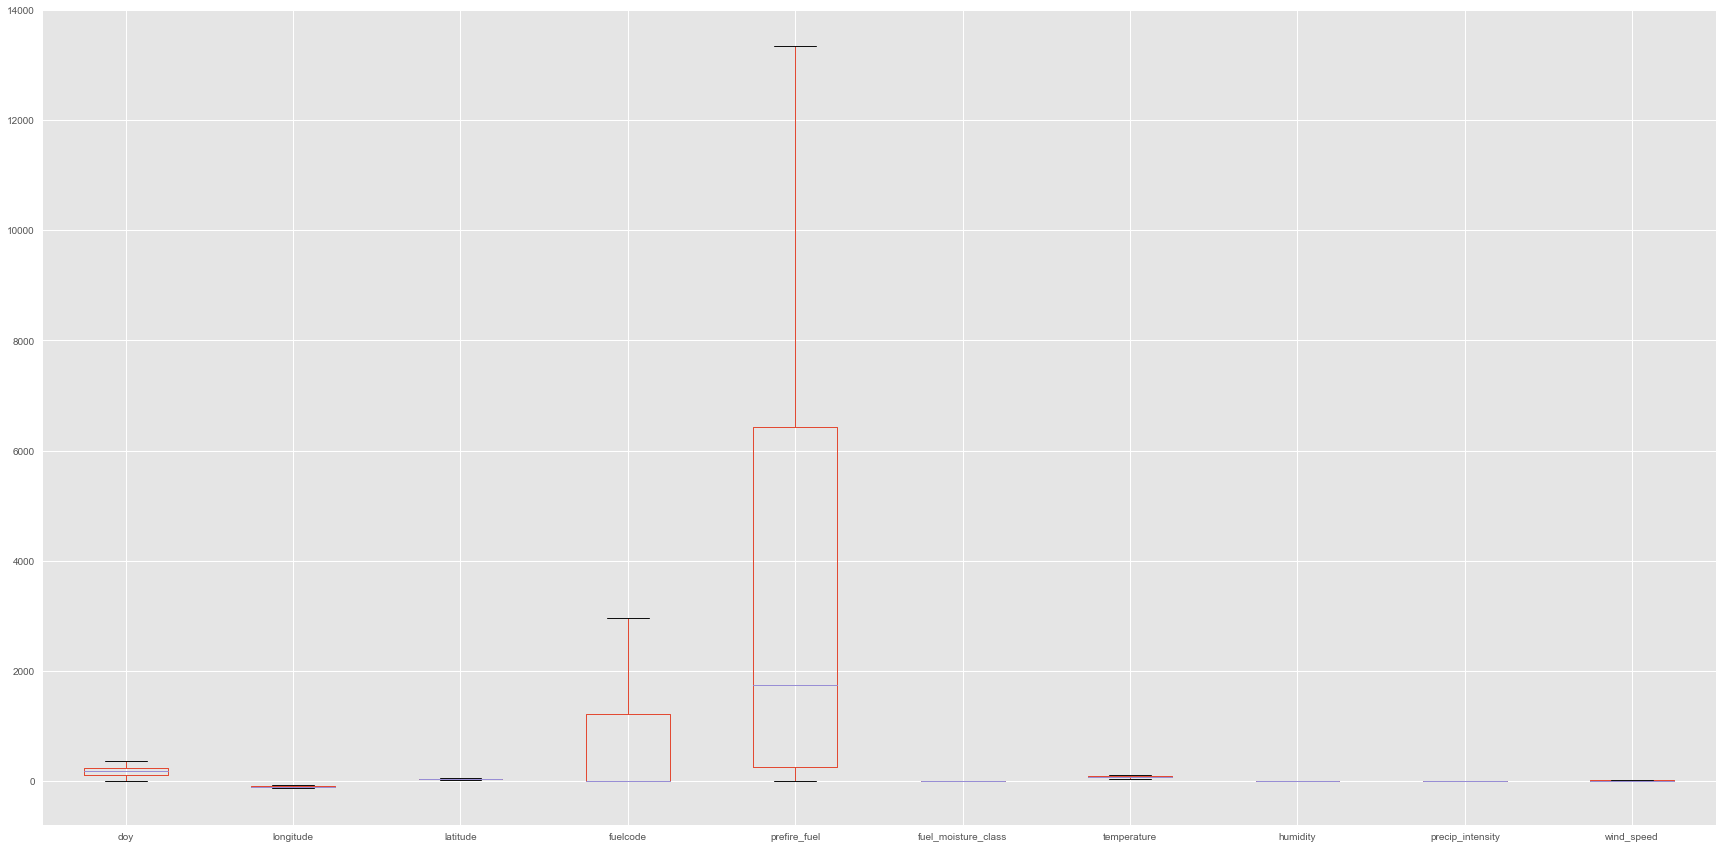

In [10]:
#draw box plot of see range of the data
import matplotlib
matplotlib.style.use('ggplot')
df_emissions.plot(kind='box',figsize=(30,15))

### View histogram of all numerical data to better understand the distribution
Graphs show some data is continous while others are categorical. 
Nothing significaiton gleamed.

In [ ]:
#historgram of all numerical data
df_emissions.hist(bins=30, figsize=(15,15))
pl.suptitle("Histogram for each numeric input variable")
plt.show()

print(df_emissions.columns)

### Let's encode fuelcode and scale numerical data to put the data in prespective
Ran StandardScaler to get a a good gauge to use. Used MinMaxScaler to remove negatives.
Scaling looks much better

In [13]:
df_emissions['fuelcode'] = LabelEncoder().fit_transform(df_emissions['fuelcode'])


feature_names = list(df_emissions.columns)


features = df_emissions[feature_names]
scaler = MinMaxScaler().fit_transform(features.values, (0, 50))

df_emissions[feature_names] = scaler

X = df_emissions[feature_names]


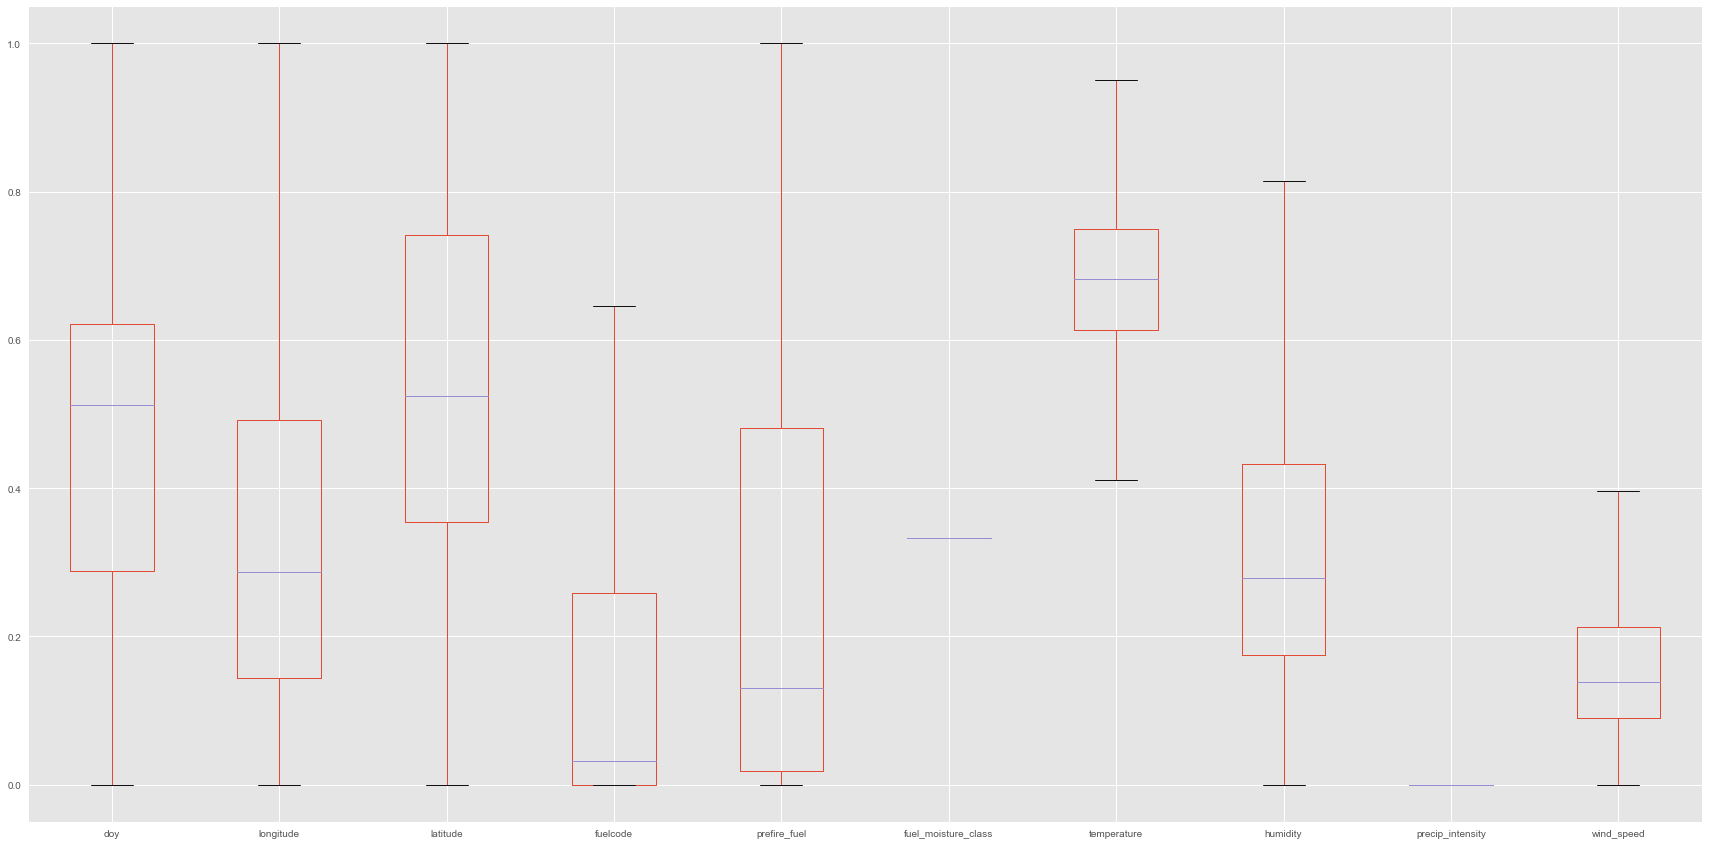

In [14]:
import matplotlib

matplotlib.style.use('ggplot')
df_emissions.plot(kind='box',figsize=(30,15))

### Scatter matrix plot for the continous values - categorical does not present much value
<i>Scatter Plot did not realize anything exciting but sure took a while to run. Avoid for future runs</i> 

In [ ]:
#draw scatter matrix - skip running

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':10}, figsize=(30,30), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')


### Generate new data to even out this bins for classification

In [15]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)


X.tail(5)

,doy,longitude,latitude,fuelcode,prefire_fuel,fuel_moisture_class,temperature,humidity,precip_intensity,wind_speed
226007,0.613699,0.049634,0.879545,0.322581,0.523872,0.000000,0.673336,0.412371,0.0,0.069550
226008,0.553425,0.168364,0.889884,0.322581,0.523872,0.333333,0.683378,0.254985,0.0,0.066924
226009,0.695890,0.577380,0.951700,0.064516,0.636594,1.000000,0.716660,0.391753,0.0,0.235369
226010,0.539769,0.061699,0.944336,0.225806,0.481450,0.000000,0.665244,0.360184,0.0,0.131523
226011,0.741395,0.212107,0.467019,0.322581,0.523872,0.333333,0.684536,0.124666,0.0,0.073403


### RadViz Show which features likely have the most impact of Burn Serverity 
<i> Based on the data and this model fuel code, fuel mositure, lat, and lon are most predictive of burn serverity. No clear strong indicators but very slight leanings. True for both scaled and unscaled.</i>

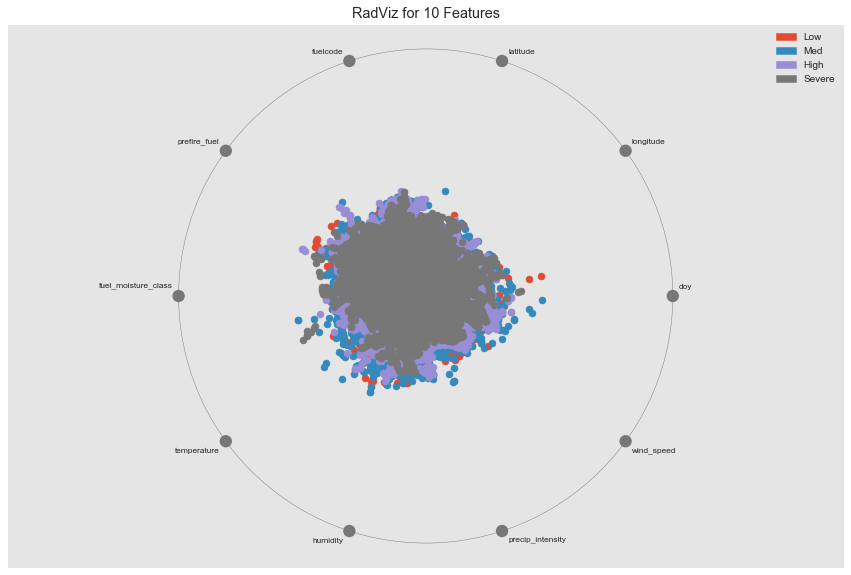

In [16]:
# Specify the target classes, burn severity 
classes = ["Low", "Med", "High", "Severe"]


# Instantiate the visualizer
visualizer = RadViz(classes=classes, features=feature_names, size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)       # Transform the data
visualizer.show()              # Draw the data

### Show RandomForestClassifier's most important features to predict severity

<i>Based on other modeling tuning we believe RandomForest and Bag Classifier will work the best so we'll run  FeatureImportances on RandomForestClassifier  </i>

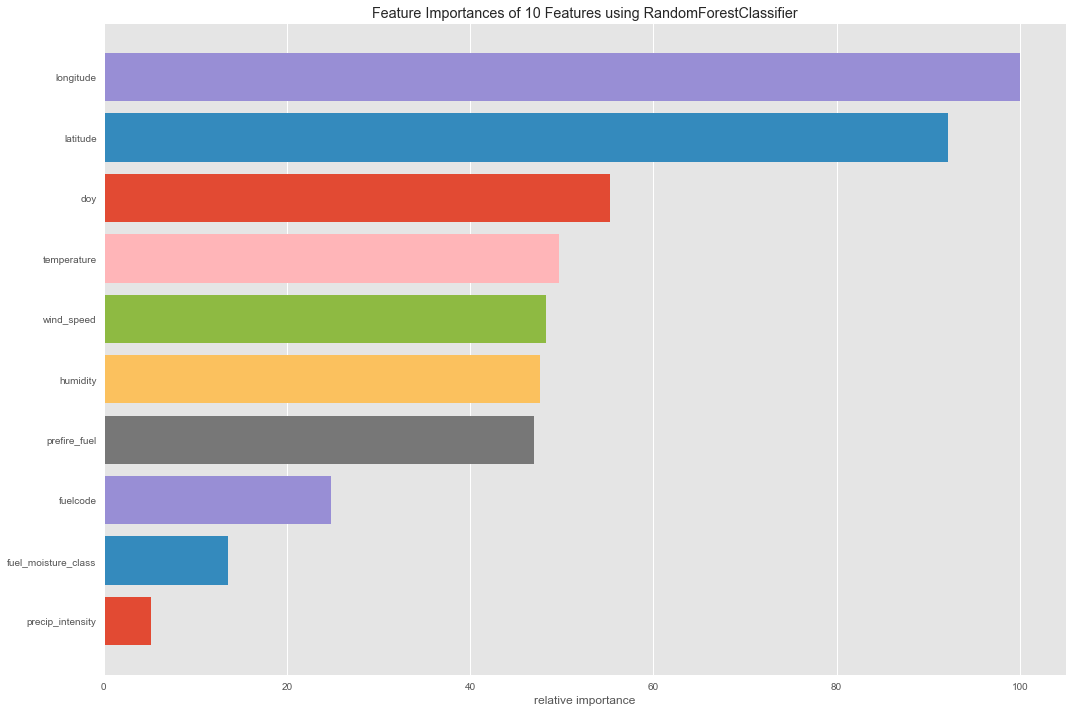

In [17]:
model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, labels=feature_names, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()


### Let's see whats important to NB
Model doesn not work well

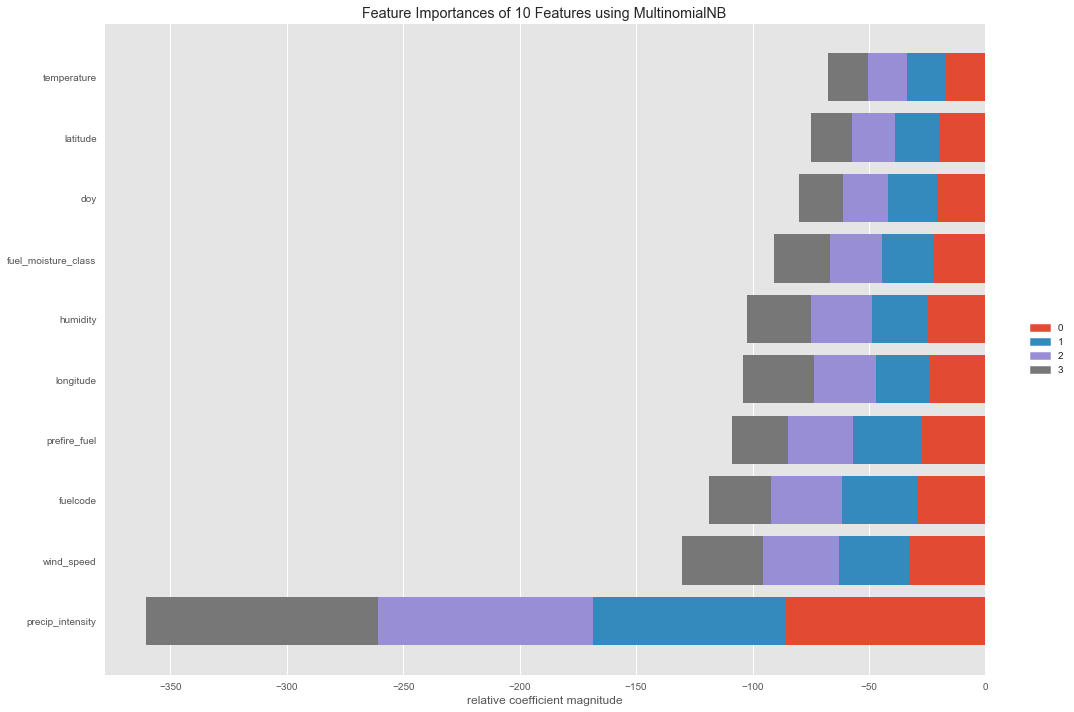

In [21]:
model = MultinomialNB()
viz = FeatureImportances(model, stack='true', labels=feature_names, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

### Check the learning curve to see if we have optimal data
Unfortunately the learning curve did not return much useful information but
based on our other model evalution notebook we decided Bagging Classifier and RandomForest performed the best for our dataset 

Will try to SMOTE to create more data

In [22]:
# Create the learning curve visualizer hyperparmeters 

#10 splits between .3 and 1
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 5)

In [ ]:
### Gaussian NB Did not perform well

In [ ]:
# Instantiate the classification model and visualizer
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=5
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


### MultinomialNB did no perform well

In [ ]:
# Instantiate the classification model and visualizer

model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=10
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


### Bagging Classifier performs the best but still only slightly above .5 . When given more data with SMOTE performance improves to .7.

In [ ]:
# Instantiate the classification model and visualizer
model = BaggingClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

### RandomForest Classifier performs the about the same as Bagging but slightly above 50 percent. When given more data with SMOTE performance improves to .7.

In [ ]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=15)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=15
)



visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


In [ ]:
### AdaBoost Did not Perform well

In [ ]:
model = AdaBoostClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

## Final Findings On Features
For the recommend features to explore with the models for the emission data setare:
'doy', 'longitude', 'latitude','fuelcode', 'prefire_fuel', 'fuel_moisture_class', 'temperature',
'humidity', 'precip_intensity', 'wind_speed' 